In [1]:
# Importing libraries
import pandas as pd
import numpy as np

#Viz
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

#preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

#ml
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans, DBSCAN

import warnings
# ignoring warnings 
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
files_2014 = ['data/uber-raw-data-apr14.csv',
            'data/uber-raw-data-may14.csv',
            'data/uber-raw-data-jun14.csv',
            'data/uber-raw-data-jul14.csv',
            'data/uber-raw-data-aug14.csv',
            'data/uber-raw-data-sep14.csv']

df14 = pd.DataFrame()
for file in files_2014:
    df = pd.read_csv(file,encoding='utf-8')
    df14 = pd.concat([df,df14])

In [3]:
df14.head()

,Date/Time,Lat,Lon,Base
0,9/1/2014 0:01:00,40.2201,-74.0021,B02512
1,9/1/2014 0:01:00,40.7500,-74.0027,B02512
2,9/1/2014 0:03:00,40.7559,-73.9864,B02512
3,9/1/2014 0:06:00,40.7450,-73.9889,B02512
4,9/1/2014 0:11:00,40.8145,-73.9444,B02512


### 1. Data Exploration

In [4]:
df = df14.copy()

In [5]:
df.shape

(4534327, 4)

In [6]:
df.dtypes

Date/Time     object
Lat          float64
Lon          float64
Base          object
dtype: object

In [7]:
df.isna().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64

### 2. Data modification

In [8]:
# Conversion des dates en colonne "datetime"
df['Date/Time'] = pd.to_datetime(df['Date/Time'], format='%m/%d/%Y %H:%M:%S')

In [9]:
df['month'] = df['Date/Time'].dt.month_name()
df['weekday'] = df['Date/Time'].dt.day_name()
df['day'] = df['Date/Time'].dt.day
df['hour'] = df['Date/Time'].dt.hour
df['minute'] = df['Date/Time'].dt.minute

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4534327 entries, 0 to 564515
Data columns (total 9 columns):
 #   Column     Dtype         
---  ------     -----         
 0   Date/Time  datetime64[ns]
 1   Lat        float64       
 2   Lon        float64       
 3   Base       object        
 4   month      object        
 5   weekday    object        
 6   day        int32         
 7   hour       int32         
 8   minute     int32         
dtypes: datetime64[ns](1), float64(2), int32(3), object(3)
memory usage: 294.1+ MB


In [11]:
# Réinitialiser les index pour qu'ils soient continus à partir de zéro
df.reset_index(drop=True, inplace=True)

In [12]:
df

,Date/Time,Lat,Lon,Base,month,weekday,day,hour,minute
0,2014-09-01 00:01:00,40.2201,-74.0021,B02512,September,Monday,1,0,1
1,2014-09-01 00:01:00,40.7500,-74.0027,B02512,September,Monday,1,0,1
2,2014-09-01 00:03:00,40.7559,-73.9864,B02512,September,Monday,1,0,3
3,2014-09-01 00:06:00,40.7450,-73.9889,B02512,September,Monday,1,0,6
4,2014-09-01 00:11:00,40.8145,-73.9444,B02512,September,Monday,1,0,11
...,...,...,...,...,...,...,...,...,...
4534322,2014-04-30 23:22:00,40.7640,-73.9744,B02764,April,Wednesday,30,23,22
4534323,2014-04-30 23:26:00,40.7629,-73.9672,B02764,April,Wednesday,30,23,26
4534324,2014-04-30 23:31:00,40.7443,-73.9889,B02764,April,Wednesday,30,23,31
4534325,2014-04-30 23:32:00,40.6756,-73.9405,B02764,April,Wednesday,30,23,32


### 3. Data Visualization

<Axes: xlabel='weekday', ylabel='count'>

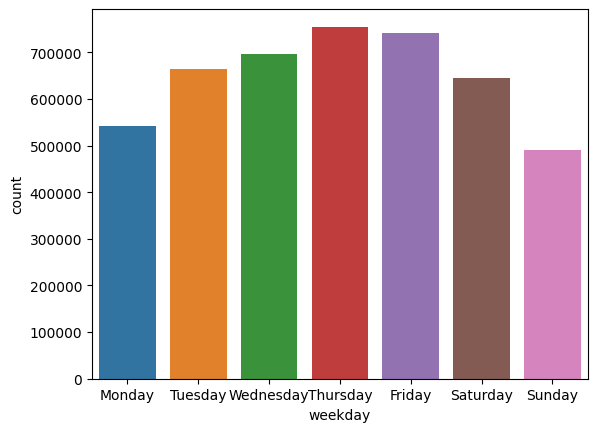

In [13]:
# Visualisation du nombre de courses / jours de la semaine
sns.countplot(df, x='weekday')

<Axes: xlabel='month', ylabel='count'>

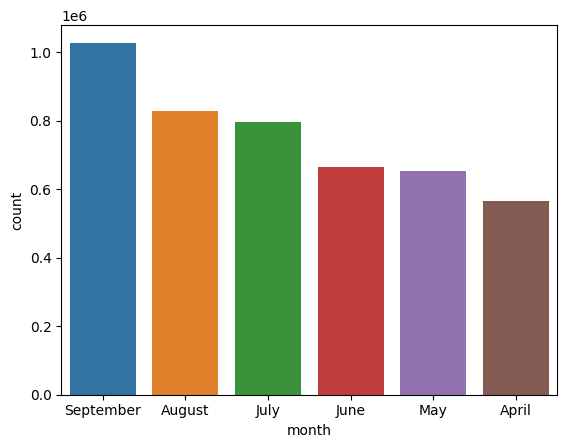

In [14]:
# Visualisation du nombre de courses / mois 
sns.countplot(df, x='month')

<Axes: xlabel='hour', ylabel='count'>

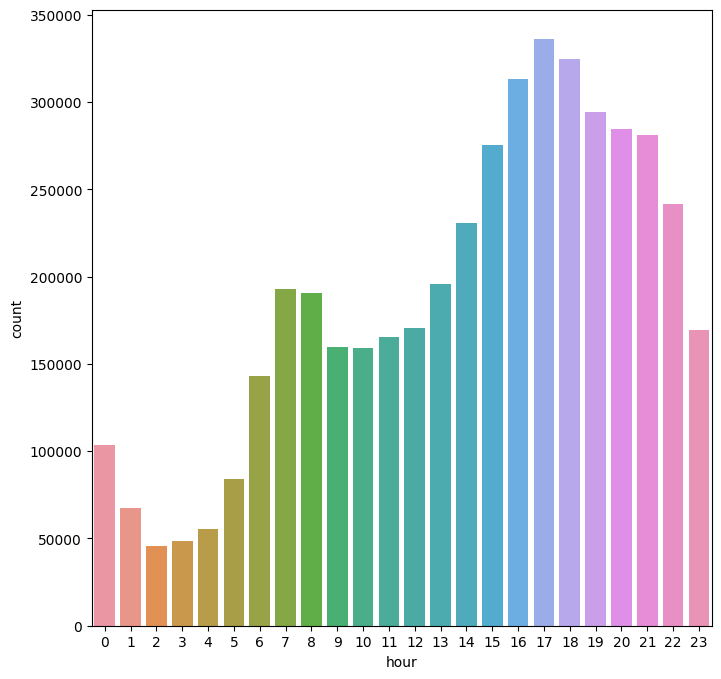

In [15]:
# Visualisation du nombre de courses/heures
plt.figure(figsize=(8,8))
sns.countplot(df, x='hour')

<Axes: xlabel='day', ylabel='count'>

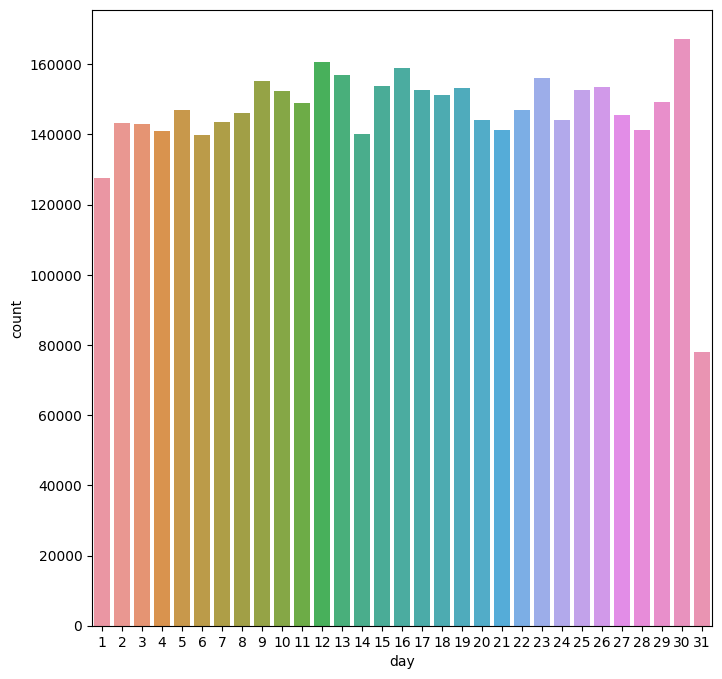

In [16]:
# Visualisation du nombre de courses / jours du mois
plt.figure(figsize=(8,8))
sns.countplot(df, x='day')

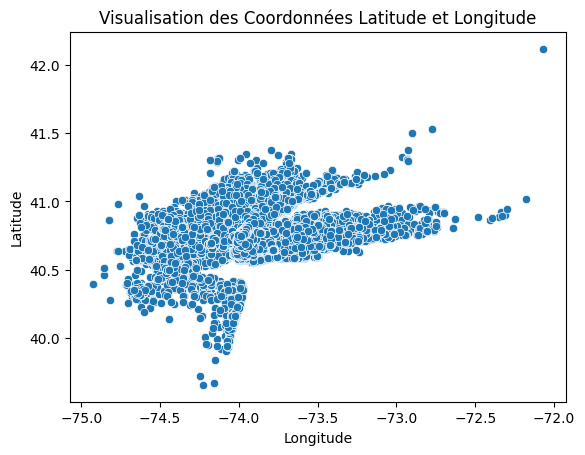

In [17]:
sns.scatterplot(x='Lon', y='Lat', data=df)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Visualisation des Coordonnées Latitude et Longitude')
plt.show()

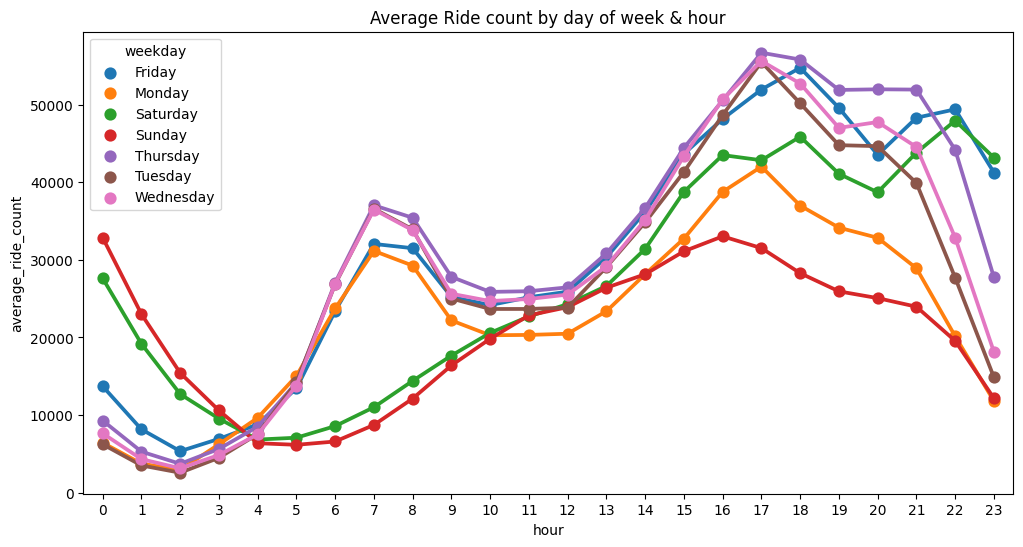

In [18]:
hourly_avg = df.groupby(['hour','weekday'])['Date/Time'].count().reset_index()
daily_hourly_avg = hourly_avg.groupby(['weekday','hour'])['Date/Time'].mean().reset_index().rename(columns = {'Date/Time':'average_ride_count'})

plt.figure(figsize=(12,6))
sns.pointplot(x='hour',y='average_ride_count',hue='weekday', data = daily_hourly_avg).set_title('Average Ride count by day of week & hour')
plt.show()

Peaks occur in the morning around 7am and in the evening around 5 and 6pm. We can see that the morning peak does not occur during sunday and saturday which can be explained by the fact that uber rides are most likely to be used for work "trip". Peak hours correspond to the begining of the work day and the end of the work day. During the weekend this graph show some differences with the number of rides on saturday and friday's night that are really important compared with other days.

In [ ]:
sample = df.sample(10000, weights='hour', random_state=1)

fig = px.scatter_mapbox(
    sample,
    lat='Lat',
    lon='Lon',
    color='hour',
    zoom=7,
    width=800
)

fig.update_layout(
    mapbox_style="carto-positron",
    title="Rides per hour in NYC",
    margin={"r":0,"t":30,"l":0,"b":0},
)

# Affichez la carte
fig.show()

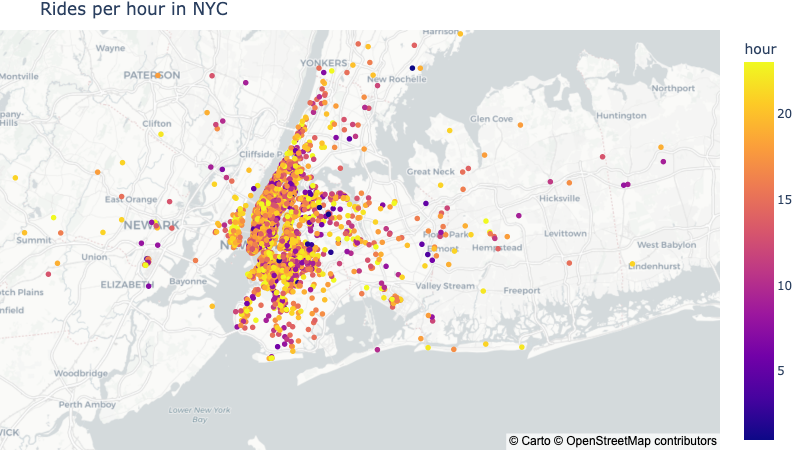

Manhattant and Brooklyn are the two district with the most rides overall the day, not really surprising I think. 

### 4. Preprocessing

In [20]:
df_sampled = df.sample(500000)

In [21]:
# preprocessing
features = ['Lat','Lon']
sc = StandardScaler()

X = sc.fit_transform(df_sampled[features])

sample_x = df.sample(100000)
sample_X = sc.fit_transform(sample_x[features])
# creating a sample for later use in DBSCAN to reduce computing time

In [22]:
# calculating inertia to estimate cluster number
wcss =  []
k = []
for i in range (1,11): 
    kmeans = KMeans(n_clusters= i, random_state = 0)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
    k.append(i)

In [ ]:
wcss_frame = pd.DataFrame(wcss)
k_frame = pd.Series(k)

fig= px.line(
    wcss_frame,
    x=k_frame,
    y=wcss_frame.iloc[:,-1]
)

fig.update_layout(
    yaxis_title="Inertia",
    xaxis_title="# Clusters",
    title="Inertia per cluster"
)

fig.show()

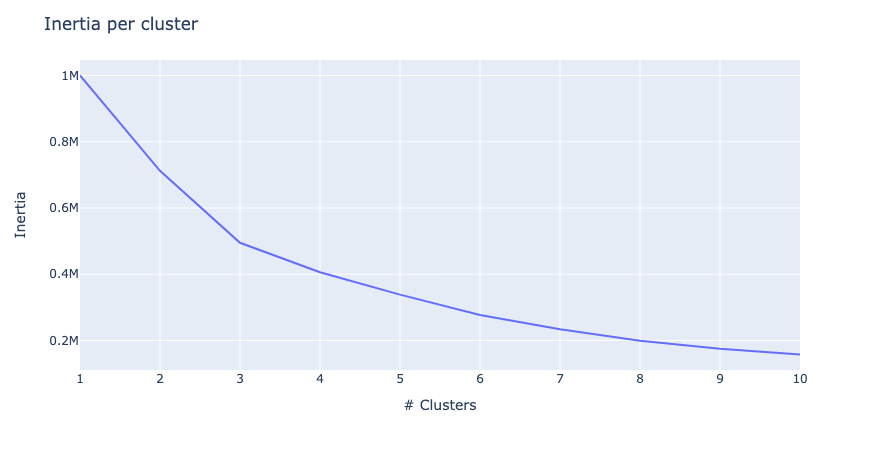

In [ ]:
sil = []
k = []
for i in range (2,11): 
    kmeans = KMeans(n_clusters= i, random_state = 1)
    kmeans.fit(sample_X)
    sil.append(silhouette_score(sample_X, kmeans.predict(sample_X)))
    k.append(i)

In [ ]:
cluster_scores=pd.DataFrame(sil)
k_frame = pd.Series(k)

fig = px.bar(data_frame=cluster_scores,  
             x=k, 
             y=cluster_scores.iloc[:, -1]
            )

fig.update_layout(
    yaxis_title="Silhouette Score",
    xaxis_title="# Clusters",
    title="Silhouette Score per cluster"
)

fig.show()

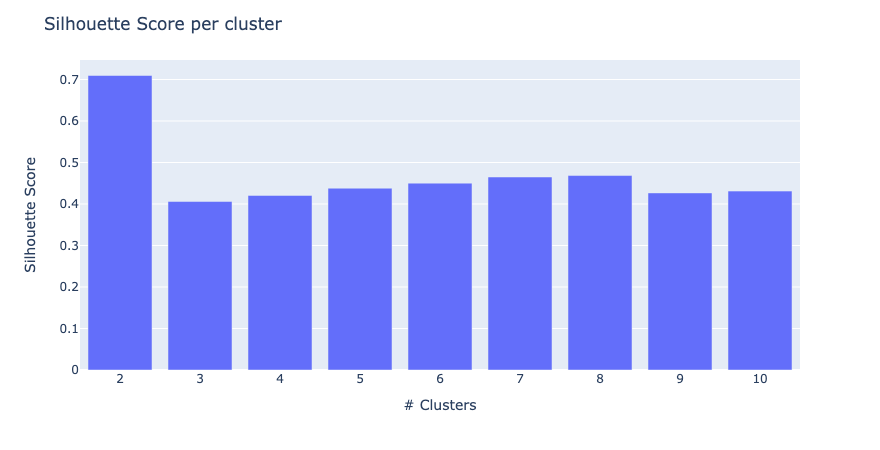

Inertia and silhouette doesn't give me the same result. We are more around 3 clusters for inertia and 2 clusters for silhouette. I don't think it is really interesting to make just 2 or 3 clusters so I will try 6 or 7 clusters.

In [25]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6, random_state=0)

# Fit kmeans to our dataset
kmeans.fit(X)

KMeans(n_clusters=6, random_state=0)

In [27]:
df_sampled['cluster'] = kmeans.labels_

In [ ]:
#creating sample to facilitate map display
df_sampled['cluster'] += 1
sample_df = df_sampled.sample(10000, weights='cluster', random_state=1)

fig = px.scatter_mapbox(
    sample_df,
    lat='Lat',
    lon='Lon',
    color='cluster',
    zoom=10
)

fig.update_layout(
    mapbox_style="carto-positron",
    title="Kmeans clusters",
    margin={"r":0,"t":30,"l":0,"b":0}
)

fig.show()

(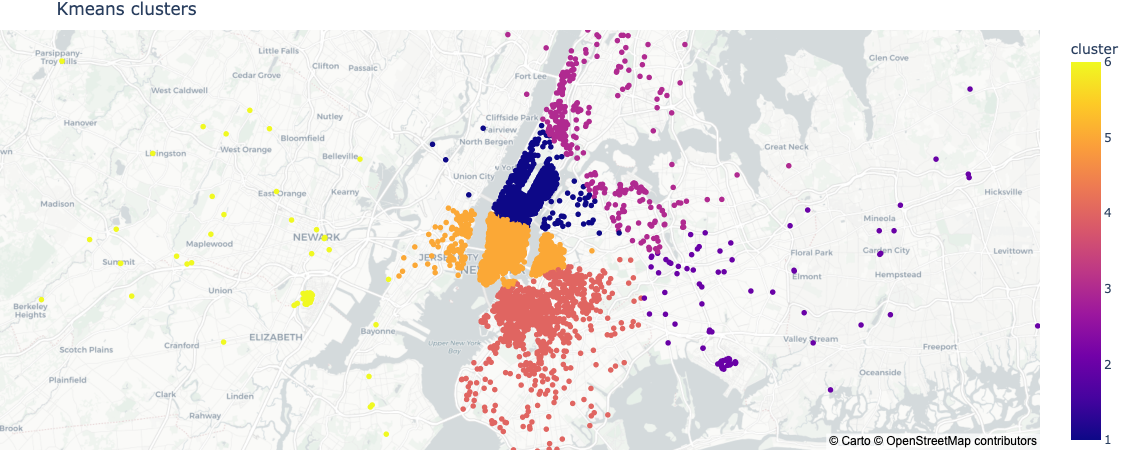)

Kmeans clusters seems pretty good, we have a big cluster for brooklyn district which is one of the most important district of New York and one with the most rides per day, same for the orange cluster with the Manhattan's major points of interest (financial district, Soho, Empire State Building, etc.), Maybe the blue cluster could be with the orange one but there's so much demand for uber in these district than it can be a good idea to separate the zone in two hot zones.

In [32]:
dbscan = DBSCAN(eps=0.2,metric='manhattan',min_samples=10)
dbscan.fit(sample_X)

sample_x['clusterDB'] = dbscan.labels_

In [ ]:
#creating sample to facilitate map display
sample_x['clusterDB'] += 1
sample_df = sample_x.sample(n=10000, weights='clusterDB', random_state=1)

fig = px.scatter_mapbox(
    sample_df,
    lat='Lat',
    lon='Lon',
    color='clusterDB',
    zoom=10
)

fig.update_layout(
    mapbox_style="carto-positron",
    title="DBSCAN clusters",
    margin={"r":0,"t":30,"l":0,"b":0}
)

fig.show()

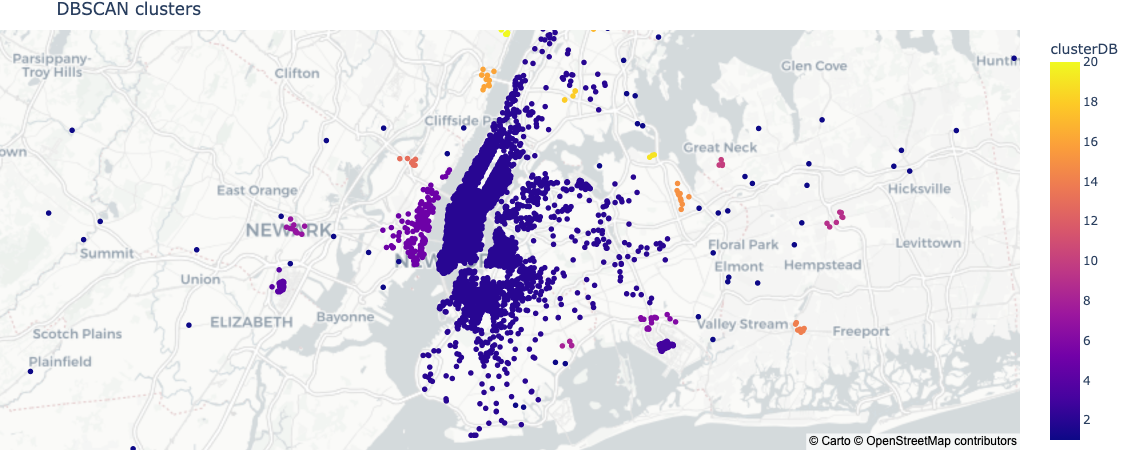

First try of DBSCAN is really bad, let's try other paramaters (I will try few and keep only the good one)

In [36]:
dbscan2 = DBSCAN(eps=0.1,metric='manhattan',min_samples=200)
dbscan2.fit(sample_X)

sample_x['clusterDB'] = dbscan2.labels_

In [ ]:
#creating sample to facilitate map display
sample_x['clusterDB'] += 1
sample_df = sample_x.sample(n=10000, weights='clusterDB', random_state=1)

fig = px.scatter_mapbox(
    sample_df,
    lat='Lat',
    lon='Lon',
    color='clusterDB',
    zoom=10
)

fig.update_layout(
    mapbox_style="carto-positron",
    title="DBSCAN clusters",
    margin={"r":0,"t":30,"l":0,"b":0}
)

fig.show()

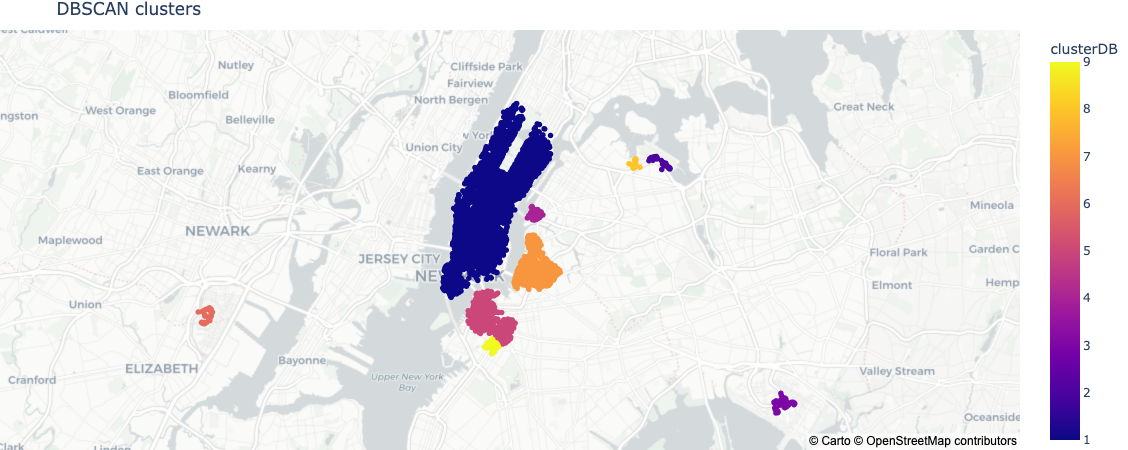

This is the best I can have for the moment. 7 clusters with good district distribution. I'm sure that it is possible to have a way better result but I tried a lot of parameters and it is quite long to run so I will stop here. The Kmeans clusters were good in my opinion.

In [43]:
df_sampled.head()

,Date/Time,Lat,Lon,Base,month,weekday,day,hour,minute,cluster
4525543,2014-04-04 07:42:00,40.7131,-73.9520,B02764,April,Friday,4,7,42,5
2142886,2014-07-01 18:13:00,40.7588,-73.9741,B02617,July,Tuesday,1,18,13,1
402941,2014-09-10 20:46:00,40.7258,-73.9947,B02617,September,Wednesday,10,20,46,5
1865629,2014-07-10 05:58:00,40.7622,-73.9959,B02512,July,Thursday,10,5,58,1
1460740,2014-08-15 19:58:00,40.6878,-74.1811,B02617,August,Friday,15,19,58,6


In [64]:
df_sampled.groupby(['cluster', 'Lat', 'Lon']).size()

cluster  Lat      Lon     
1        40.7241  -73.8988    1
         40.7244  -73.9036    1
         40.7245  -73.8996    1
         40.7246  -73.8997    1
                  -73.8996    1
                             ..
6        40.9654  -74.5996    1
         40.9797  -74.2768    1
         40.9882  -74.3236    2
         41.0077  -74.2953    1
         41.0250  -74.2942    1
Length: 203804, dtype: int64

In [ ]:
def get_hotzones(df, hour, day_of_week):
    filtered_df = df[(df['hour'] == hour) & (df['weekday'] == day_of_week)]
    hotzones = filtered_df.groupby(['cluster','Lat','Lon']).size().reset_index()
    return hotzones

# Choisissez une heure et un jour de la semaine spécifiques
df = df_sampled
target_hour = 22  # Par exemple, midi
target_day_of_week = "Tuesday" # Par exemple, mercredi (0 = lundi, 1 = mardi, ..., 6 = dimanche)

hotzones_data = get_hotzones(df, target_hour, target_day_of_week)

# Créez une carte Plotly pour visualiser les hotzones
fig = px.scatter_mapbox(
    hotzones_data,
    lat='Lat',
    lon='Lon',
    color='cluster',
    zoom=10,
    title=f'Hotzones à {target_hour}:00 le jour {target_day_of_week}',
)

fig.update_layout(
    mapbox_style="carto-positron",
    margin={"r":0,"t":30,"l":0,"b":0}
)

fig.show()

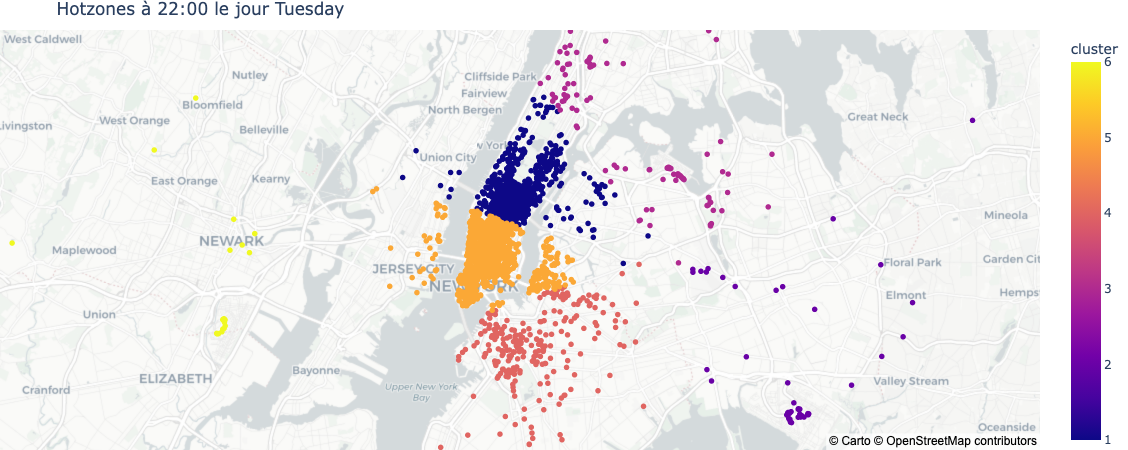